# Training CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [31]:
import numpy as np
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torchviz import make_dot
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from numpy import random
from PIL import Image
from PIL import ImageDraw
from PIL import ImageOps
from PIL import ImageFilter
from scipy.ndimage.filters import gaussian_filter
from sklearn.preprocessing import StandardScaler

%matplotlib inline

print(torch.__version__)

1.0.1.post2


Fix random seed to make sure we get reproducible results. This can be removed at production stage.

In [19]:
my_seed = 12345
random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)

Define a class that is used to generate streak images, which we will use to produce our training/validation/test sets

In [60]:
class StreakImageGenerator:
    def __init__(self, windowSize, maxDisplacement, nparticles,\
                 radius, uRms, phiRms):
        self.winSz = windowSize
        self.maxDisplacement = maxDisplacement
        self.nparticles = nparticles
        self.radius = radius
        self.uRms = uRms
        self.phiRms = phiRms
        
    def generate(self, count = 1, sigma = None, truncate = None):
        images = np.zeros([count, 1, self.winSz, self.winSz], dtype=np.float32)
        un0 = np.zeros(count, dtype=np.float32)
        phi0 = np.zeros(count, dtype=np.float32)
        
        img = Image.new('L', (self.winSz,self.winSz),(0))
        draw = ImageDraw.Draw(img)

        nstreaks = random.randint(self.nparticles.start, self.nparticles.stop, count)
        
        for i in range(0, count):
            draw.rectangle((0, 0, self.winSz, self.winSz), fill=(0)) # clean image
            
            un0[i] = np.sqrt(random.uniform(0, 1)) * self.maxDisplacement
            phi0[i] = random.uniform(0, np.pi) - np.pi / 2    
                        
            x_start = random.uniform(0, self.winSz, nstreaks[i])
            y_start = random.uniform(0, self.winSz, nstreaks[i])
        
            un = un0[i] + random.uniform(.0, self.uRms, nstreaks[i])
            phi = phi0[i] + random.uniform(-self.phiRms * np.pi / 180 / 2, self.phiRms * np.pi / 180 / 2, nstreaks[i])
            
            Dx = un * np.cos(phi)
            Dy = un * np.sin(phi)
            x_end = x_start + Dx 
            y_end = y_start + Dy 
            
            for j in range(nstreaks[i]):
                width = random.randint(self.radius.start, self.radius.stop)
                intensity = random.randint(200, 255)
                draw.line(((x_start[j], y_start[j]), \
                           (x_end[j], y_end[j])), fill=intensity, width=width)
                
            if sigma is None:
                images[i,0,:,:] = img;
            else:
                images[i,0,:,:] = gaussian_filter(np.asarray(img), sigma=sigma, truncate=truncate)
                #images[i,0,:,:] = ImageOps.autocontrast(Image.fromarray(img))
                #images[i,0,:,:] = img.filter(ImageFilter.GaussianBlur(radius=sigma))
                #images[i,0,:,:] = 255. * (1. - np.exp(-0.006*images[i,0,:,:]))
                
        return images,un0,phi0*180/np.pi,nstreaks

Specify and generate training an validation sets

(array([15.78870996,  0.82773346]), array([ 5.72802183, 51.89767953]))


(array([ 86., 111., 101., 100.,  97.,  94.,  98., 113.,  93., 107.]),
 array([-1.7472914 , -1.4011334 , -1.0549754 , -0.7088174 , -0.3626594 ,
        -0.01650137,  0.32965666,  0.6758147 ,  1.0219727 ,  1.3681307 ,
         1.7142887 ], dtype=float32),
 <a list of 10 Patch objects>)

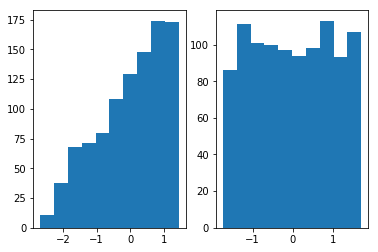

In [63]:
windowSize = 48
generator = StreakImageGenerator(windowSize, maxDisplacement = 24, \
                                 nparticles = range(2, 10), radius = range(1, 4), \
                                 uRms = 0, phiRms = 0)

trainCount = 1000;
trainImages, trainUn, trainPhi, _ = generator.generate(count = trainCount, sigma = 1, truncate = 2)

validationCount = 1000;
validationImages, validationUn, validationPhi, _ = generator.generate(count = validationCount, sigma = 1, truncate = 2)

# Preprocess data
scaler = StandardScaler()
trainData = scaler.fit_transform(np.column_stack((trainUn, trainPhi)))
validationData = scaler.transform(np.column_stack((validationUn, validationPhi)))

print((scaler.mean_, scaler.scale_))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(trainData[:,0])
ax = fig.add_subplot(1,2,2)
plt.hist(trainData[:,1])

Display random images and their parameters

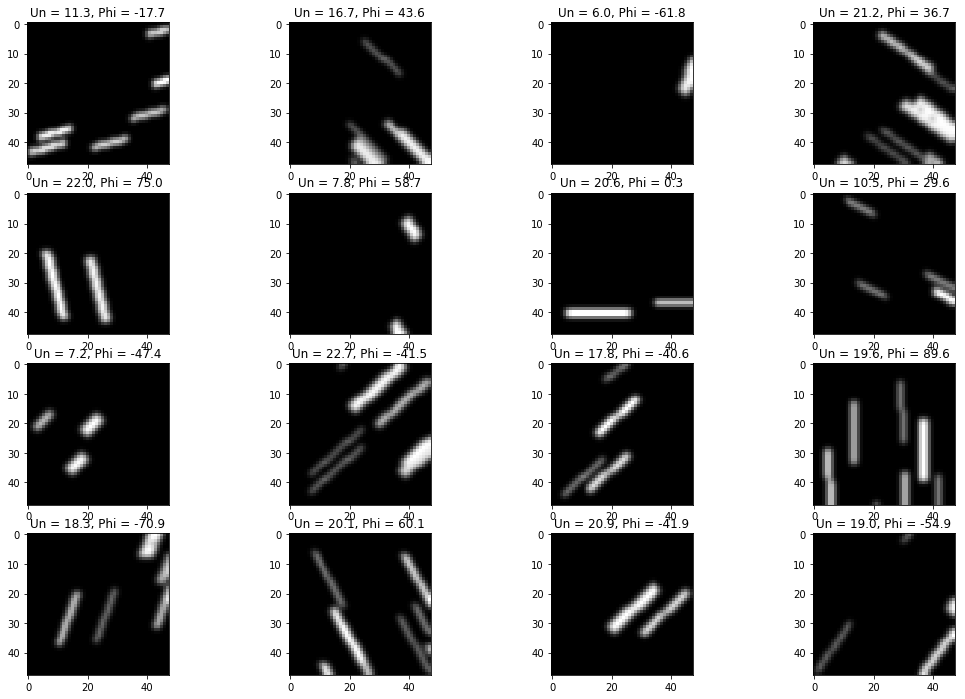

In [64]:
indices = random.randint(0, len(trainImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(trainImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (trainUn[indices[i]], trainPhi[indices[i]]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

## Creating and training of a CNN

Define some global settings

In [65]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Define actual network architecture

In [66]:
from torch.autograd import Variable

class StreaksCNN(torch.nn.Module):
    
    #Our batch shape for input x is (1, winSz, winSz)
    
    def __init__(self, winSz, filtSz, convPad):
        super(StreaksCNN, self).__init__()
                
        # We use the same pooling for all hidden layers
        self.cnn_part = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, kernel_size=filtSz, stride=1, padding=convPad),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.BatchNorm2d(8),

            torch.nn.Conv2d(8, 16, kernel_size=filtSz, stride=1, padding=convPad),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.BatchNorm2d(16),

            torch.nn.Conv2d(16, 32, kernel_size=filtSz, stride=1, padding=convPad),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            torch.nn.BatchNorm2d(32),
            
            torch.nn.Conv2d(32, 32, kernel_size=filtSz, stride=1, padding=convPad),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32)
        )

        self.dropout = torch.nn.Dropout2d(0.2) 
                
        #1152 input features, 2 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(6 * 6 * 32, 2)
                
    def forward(self, x):
        x = self.cnn_part(x)
        x = self.dropout(x)
        
        #Size changes from (32, 6, 6) to (1, 1152)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 6 * 6 * 32)
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 1152) to (1, 2)
        x = self.fc1(x)
        
        return(x)
    
def apply_dropout(m):
    if type(m) == nn.Dropout2d:
        m.train()

Convert data into pytorch compatible format

In [67]:
params = {'batch_size': 20,
          'shuffle': True,
          'num_workers': 0}

xtrain = torch.from_numpy(trainImages)
ytrain = torch.from_numpy(trainData)

train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, **params)

#for batch_idx, (x, y) in enumerate(train_loader):
#    print(x.shape, y.shape)

xvalidation = torch.from_numpy(validationImages)
yvalidation = torch.from_numpy(validationData)

validation_dataset = TensorDataset(xvalidation, yvalidation)
validation_loader = DataLoader(validation_dataset, **params)

Perform training

In [69]:
learning_rate = 3e-4

net = StreaksCNN(winSz = windowSize, filtSz = 5, convPad = 2)
loss = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

n_epochs = 20
n_batches = len(train_loader)

# Time for printing
training_start_time = time.time()

train_loss_log = np.zeros(n_epochs)
validation_loss_log = np.zeros(n_epochs)

# Loop for n_epochs
for epoch in range(n_epochs):
        
    print_every = n_batches // 5
    start_time = time.time()
    total_train_loss = 0
        
    net.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs
        inputs, labels = data
            
        # Wrap them in a Variable object
        inputs, labels = Variable(inputs), Variable(labels)
                
        # Set the parameter gradients to zero
        optimizer.zero_grad()
            
        # Forward pass, backward pass, optimize
        outputs = net(inputs)
        
        loss_size = loss(outputs, labels)
        loss_size.backward()
        optimizer.step()
            
        total_train_loss += loss_size.item()
            
        #if (i + 1) % (print_every + 1) == 0:
        #    print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
        #          epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
        
        # Reset time
        start_time = time.time()
    
    # At the end of the epoch, do a pass on the validation set
    net.eval()
    total_val_loss = 0
    for inputs, labels in validation_loader:
        # Wrap tensors in Variables
        inputs, labels = Variable(inputs), Variable(labels)
            
        # Forward pass
        val_outputs = net(inputs)
        val_loss_size = loss(val_outputs, labels)
        total_val_loss += val_loss_size.item()
                
    train_loss_log[epoch] = total_train_loss / len(train_loader)
    validation_loss_log[epoch] = total_val_loss / len(validation_loader)
    
    print("Train loss = {:.2f}, Validation loss = {:.2f}".format(train_loss_log[epoch], validation_loss_log[epoch]))
        
print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

Train loss = 33.32, Validation loss = 22.59
Train loss = 20.28, Validation loss = 20.53
Train loss = 16.59, Validation loss = 11.79
Train loss = 13.57, Validation loss = 11.57
Train loss = 11.68, Validation loss = 8.06
Train loss = 10.26, Validation loss = 6.93
Train loss = 8.99, Validation loss = 6.01
Train loss = 8.17, Validation loss = 5.80
Train loss = 7.40, Validation loss = 4.77
Train loss = 6.99, Validation loss = 4.72
Train loss = 6.34, Validation loss = 4.58
Train loss = 5.84, Validation loss = 3.07
Train loss = 5.05, Validation loss = 2.96
Train loss = 4.86, Validation loss = 2.74
Train loss = 4.38, Validation loss = 2.49
Train loss = 4.53, Validation loss = 2.19
Train loss = 4.14, Validation loss = 2.22
Train loss = 3.92, Validation loss = 1.87
Train loss = 3.80, Validation loss = 1.85
Train loss = 3.96, Validation loss = 1.75
Training finished, took 66.30s


Once the network is trained, let us display some learning statistics and model information

Text(0, 0.5, 'Loss')

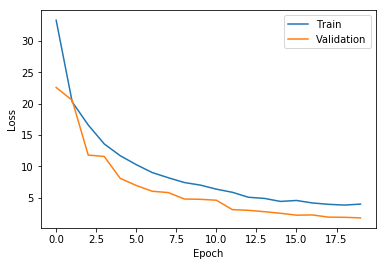

In [70]:
fig = plt.figure()
plt.plot(train_loss_log, '')
plt.plot(validation_loss_log)
plt.legend(('Train', 'Validation'))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Print model summary

In [30]:
print(net)

StreaksCNN(
  (cnn_part): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout2d(p=0.2)
  (fc1): Linear(in_features=1152, out_feat

Display computational graph

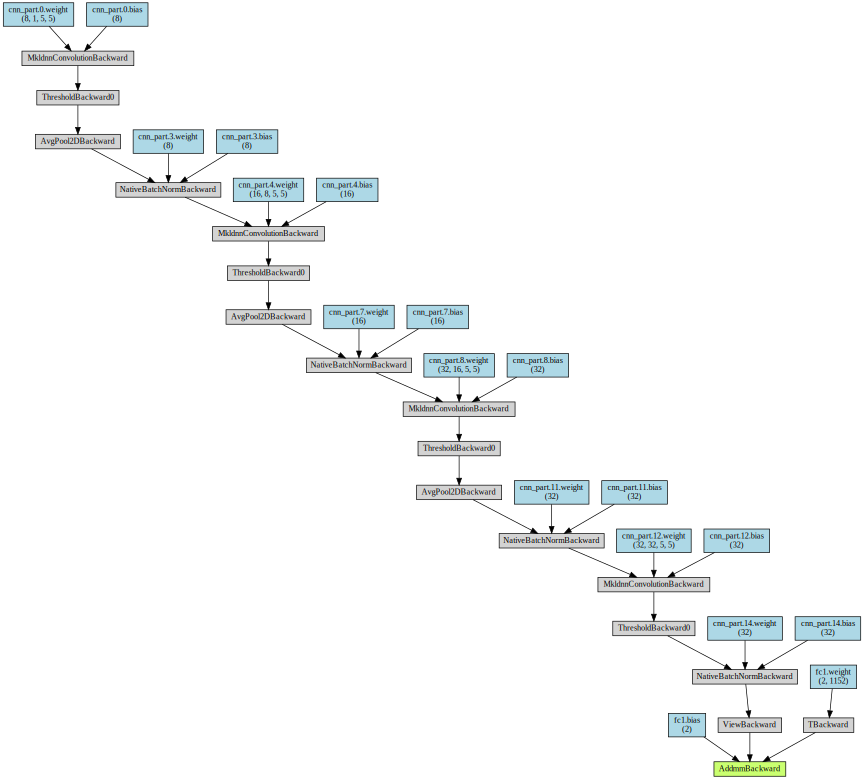

In [28]:
x = torch.randn(params['batch_size'],1,windowSize,windowSize)
make_dot(net(x), params=dict(net.named_parameters()))